In [1]:
from src.phishIRISData import PhishIRISData
import matplotlib.pyplot as plt
import numpy as np
import cv2

data = PhishIRISData().get_data()

In [2]:
# split to training and testing data - train_test_split
from sklearn.model_selection import train_test_split

images_training, images_testing = train_test_split(data.imgs, test_size=0.2)

In [38]:
def read_bw_images(img_paths):
    """
    Read images and convert them to black and white
    :param img_paths:
    :return: list of black and white images
    """
    return [
        cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
        if len(cv2.imread(img_path).shape) == 3
        else cv2.imread(img_path)
        for img_path in img_paths
    ]

In [5]:
bw_images = []
for img_path in images_training:
    # if RGB, transform into grayscale
    img = cv2.imread(img_path)
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images.append(img)

In [43]:
def clean_descriptors(
    keypoints: list[cv2.KeyPoint], descriptors: list[np.ndarray]
) -> tuple[list[cv2.KeyPoint], list[np.ndarray]]:
    print(f"len before: {len(descriptors)}")
    # initialize list to store idx values of records to drop
    to_drop = []
    for i, img_descriptors in enumerate(descriptors):
        # if there are no descriptors, add record idx to drop list
        if img_descriptors is None:
            to_drop.append(i)

    print(f"indexes: {to_drop}")
    # delete from list in reverse order
    for i in sorted(to_drop, reverse=True):
        del descriptors[i], keypoints[i]

    print(f"len after: {len(descriptors)}")
    return keypoints, descriptors

In [44]:
def run_sift(images, clean=True) -> tuple[list[cv2.KeyPoint], list[np.ndarray]]:
    """
    Run SIFT on a list of black and white images
    :param images:
    :return: list of keypoints and descriptors
    """
    sift = cv2.SIFT_create()
    keypoints_agg: list[cv2.KeyPoint] = []
    descriptors_agg: list[np.ndarray] = []
    for img in images:
        # extract keypoints and descriptors for each image
        img_keypoints, img_descriptors = sift.detectAndCompute(img, None)
        keypoints_agg.append(img_keypoints)
        descriptors_agg.append(img_descriptors)

    return clean_descriptors(
        keypoints_agg, descriptors_agg
    ) if clean else keypoints_agg, descriptors_agg

In [45]:
test_bw_images = read_bw_images(images_testing)
keypoints_t, descriptors_t = run_sift(test_bw_images)

len before: 183
indexes: []
len after: 183


In [4]:
# defining feature extractor that we want to use (SIFT)
extractor = cv2.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in bw_images:
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

In [6]:
print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")

len before: 730
indexes: []
len after: 730


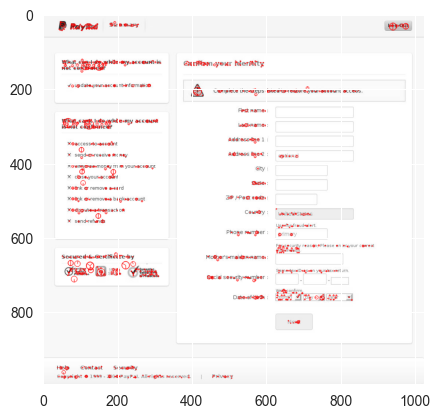

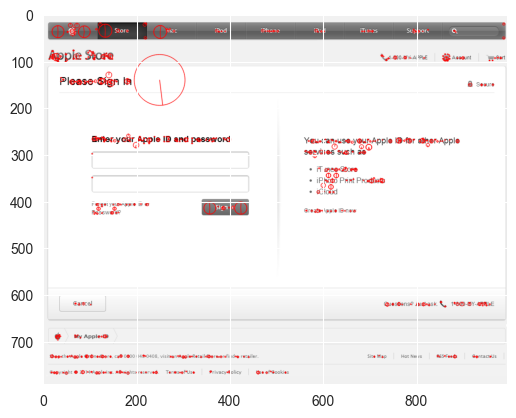

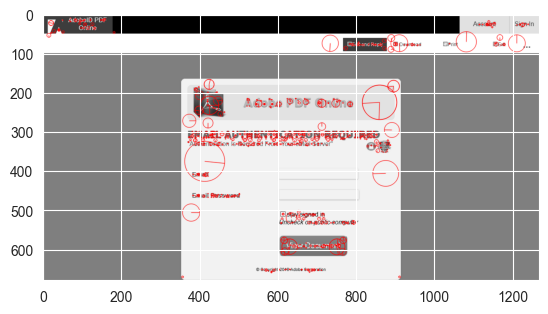

In [7]:
output_image = []
for x in range(3):
    output_image.append(
        cv2.drawKeypoints(
            bw_images[x],
            keypoints[x],
            0,
            (255, 0, 0),
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        )
    )
    plt.imshow(output_image[x], cmap="gray")
    plt.show()

In [8]:
# select the same numbers in each run
np.random.seed(42)
# select 1000 random image index values
sample_idx = np.random.randint(0, len(images_training) + 1, 1000).tolist()
len(sample_idx)

1000

In [9]:
# extract the sample from descriptors
# (we don't need keypoints)
descriptors_sample = []

for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

In [13]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in descriptors_sample:
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

In [14]:
# check the shape
all_descriptors.shape

(1850504, 128)

In [15]:
# we can count the number of descriptors contained in descriptors to confirm
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
# here we can see the number of descriptors for the first five images
print(f"first five: {count[:5]}")
# and if we sum them all, we should see the 39893 from before
print(f"count all: {sum(count)}")

first five: [8353, 1897, 1309, 1553, 2742]
count all: 1850504


In [16]:
# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans

k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

In [17]:
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3)

['bovw-codebook.pkl']

In [18]:
# load the visual features, number of clusters, and codebook
k, codebook = joblib.load("bovw-codebook.pkl")

# Vector Quantization

In [19]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [46]:
def get_visual_words(descriptors, codebook):
    visual_words = []
    for img_descriptors in descriptors:
        # for each image, map each descriptor to the nearest codebook entry
        img_visual_words, distance = vq(img_descriptors, codebook)
        visual_words.append(img_visual_words)
    return visual_words

In [48]:
def get_frequency_vectors(visual_words, k):
    frequency_vectors = []
    for img_visual_words in visual_words:
        # create a frequency vector for each image
        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        frequency_vectors.append(img_frequency_vector)
    return np.stack(frequency_vectors)

In [50]:
visual_words_t = get_visual_words(descriptors_t, codebook)
frequency_vectors_t = get_frequency_vectors(visual_words_t, k)

---

In [20]:
# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

(array([156, 187,   6,  27,  49], dtype=int32), 1448)

In [21]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [22]:
frequency_vectors.shape

(730, 200)

In [23]:
# the centroid that represents visual word 84 is of dimensionality...
codebook[79].shape  # (all have the same dimensionality)

(128,)

In [24]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [25]:
frequency_vectors.shape

(730, 200)

In [28]:
# we know from above that ids 84, 22, 45, and 172 appear in image 0
for i in [156, 187, 6, 27, 49]:
    print(f"{i}: {frequency_vectors[0][i]}")

156: 3.0
187: 25.0
6: 2.0
27: 3.0
49: 8.0


In [27]:
frequency_vectors[0][:20]

array([ 1., 15.,  6.,  0.,  0.,  3.,  2.,  2.,  7.,  0., 19.,  0.,  2.,
        1.,  3., 13.,  3.,  1., 27.,  6.])

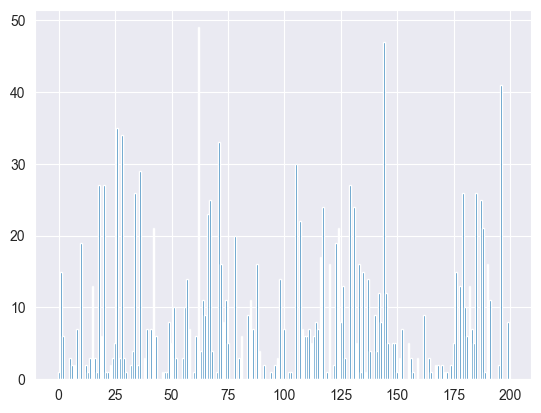

In [29]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

# Tf-Idf

In [30]:
# N is the number of images, i.e. the size of the dataset
N = len(data.imgs)

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [31]:
df.shape, df[:5]

((200,), array([429, 667, 618, 350, 581]))

In [32]:
idf = np.log(N / df)
idf.shape, idf[:5]

((200,), array([0.75527896, 0.31394583, 0.39024742, 0.95880273, 0.45198512]))

In [33]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

((730, 200),
 array([0.75527896, 4.70918752, 2.34148454, 0.        , 0.        ]))

In [55]:
def get_tfidf(frequency_vectors):
    N = len(frequency_vectors)
    df = np.sum(frequency_vectors > 0, axis=0)
    print(df.shape, df[:5])
    idf = np.log(N / df)
    print(idf.shape, idf[:5])
    print(tfidf.shape, tfidf[0][:5])
    return frequency_vectors * idf

In [57]:
tfidf_t = get_tfidf(frequency_vectors_t)

(200,) [110 171 160 100 150]
(200,) [0.50900579 0.0678226  0.13431234 0.60431597 0.19885086]
(730, 200) [0.75527896 4.70918752 2.34148454 0.         0.        ]


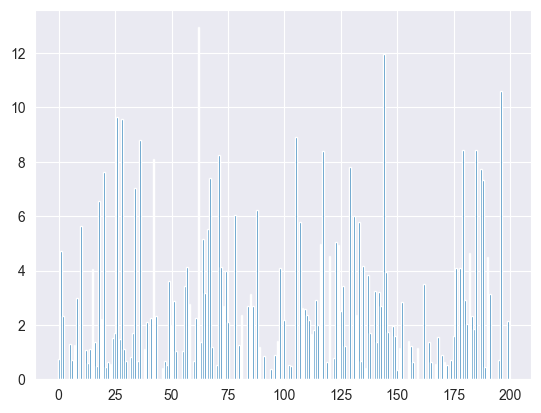

In [34]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

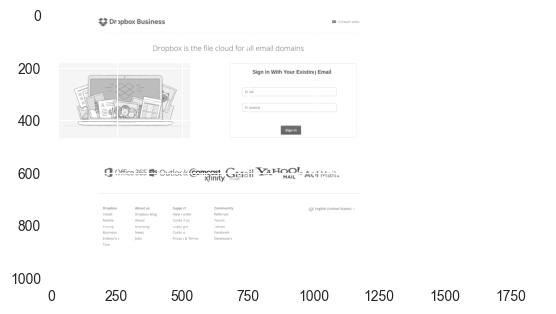

In [35]:
search_i = 333

plt.imshow(bw_images[search_i], cmap="gray")
plt.show()

In [36]:
# cosine similarity
from numpy.linalg import norm

a = tfidf[search_i]
b = tfidf  # set search space to the full sample

cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))
print("Min cosine similarity:", round(np.min(cosine_similarity), 1))
print("Max cosine similarity:", np.max(cosine_similarity))

Min cosine similarity: 0.0
Max cosine similarity: 1.0000000000000004


In [33]:
cosine_similarity.shape

(730,)

In [34]:
cosine_similarity

array([0.43664218, 0.66218306, 0.54463963, 0.4976214 , 0.49367819,
       0.52237685, 0.64168194, 0.53226169, 0.58125485, 0.53077259,
       0.35529696, 0.44313513, 0.59233457, 0.47940378, 0.6906503 ,
       0.51774969, 0.56143345, 0.51857524, 0.52503859, 0.58100006,
       0.70141823, 0.50904744, 0.49018457, 0.61065116, 0.39800121,
       0.6008931 , 0.5310286 , 0.61761534, 0.53674487, 0.54744442,
       0.46828339, 0.73824291, 0.45490013, 0.62932387, 0.48420349,
       0.4883655 , 0.6058702 , 0.5667422 , 0.41276512, 0.61018985,
       0.48866156, 0.35766267, 0.44884179, 0.47142134, 0.51610534,
       0.61914716, 0.50885363, 0.29548773, 0.51999677, 0.58919426,
       0.65471801, 0.61914716, 0.46492251, 0.56808519, 0.4866453 ,
       0.6114542 , 0.60412165, 0.65543129, 0.23593723, 0.53313934,
       0.55052782, 0.32948321, 0.44533141, 0.4093847 , 0.56335844,
       0.52250989, 0.50931887, 0.48471867, 0.35682995, 0.47728868,
       0.38653628, 0.50031663, 0.54535496, 0.59584152, 0.63301

In [35]:
top_k = 5
idx = np.argsort(-cosine_similarity)[:top_k]
idx

array([333, 195, 267, 518, 415])

In [36]:
cosine_similarity[idx[0]]

1.0000000000000004

333: 1.0


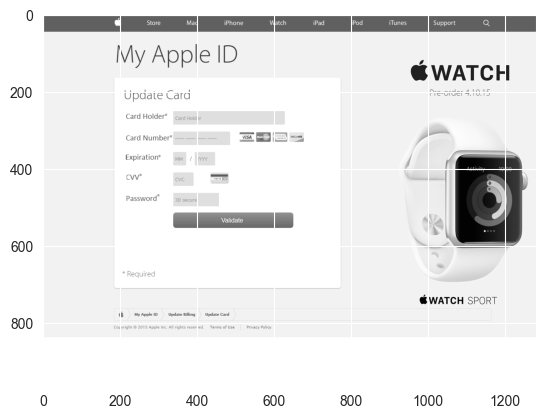

195: 0.8813


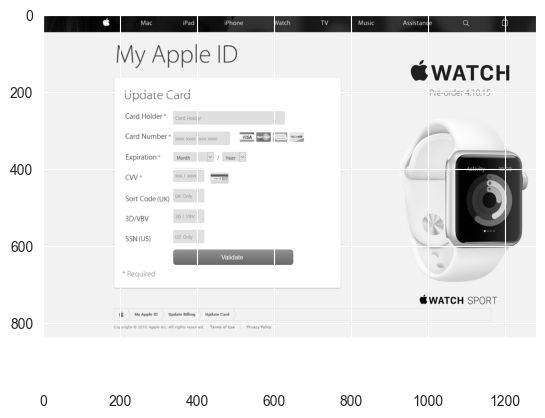

267: 0.8464


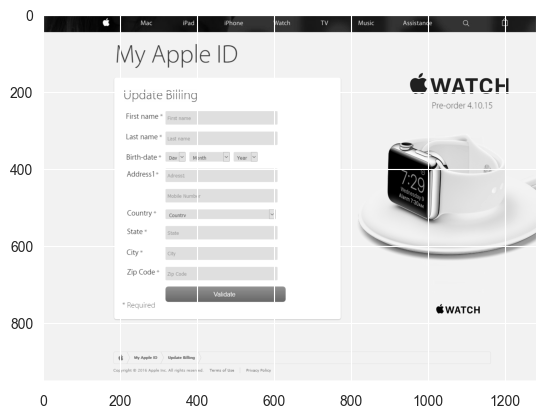

518: 0.8464


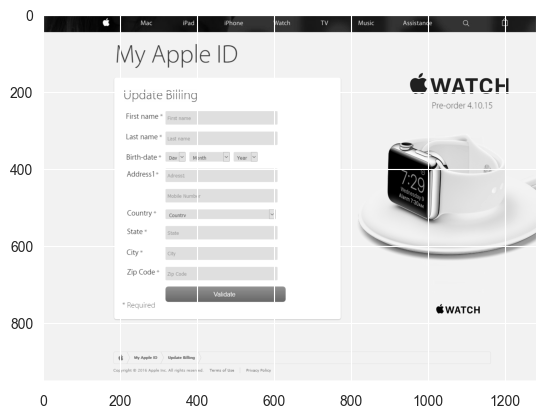

415: 0.8156


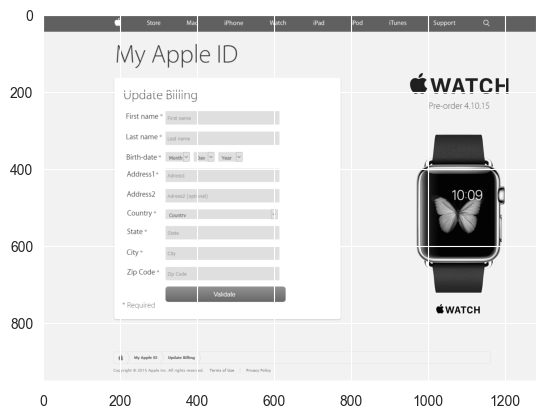

In [37]:
for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)}")
    plt.imshow(bw_images[i], cmap="gray")
    plt.show()

In [71]:
def search(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(bw_images[i], cmap="gray")
    plt.show()
    print("-----------------------------------------------------")
    # get search image vector
    a = tfidf[i]
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap="gray")
        plt.show()
    return idx

In [72]:
def search_test(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(bw_images[i], cmap="gray")
    plt.show()
    print("-----------------------------------------------------")
    # get search image vector
    a = tfidf[i]
    b = tfidf
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap="gray")
        plt.show()

    return idx

Search image:


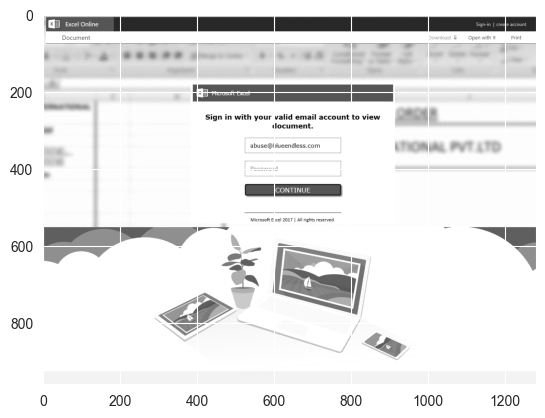

-----------------------------------------------------
647: 1.0


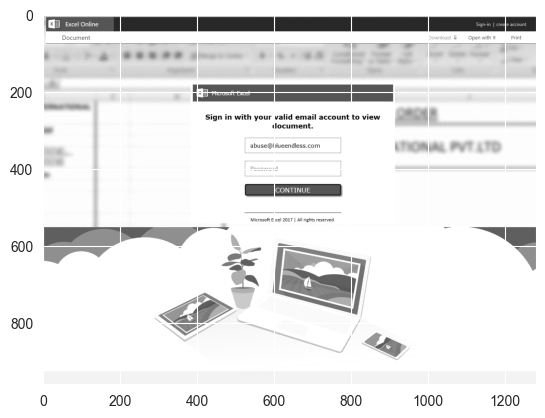

10: 1.0


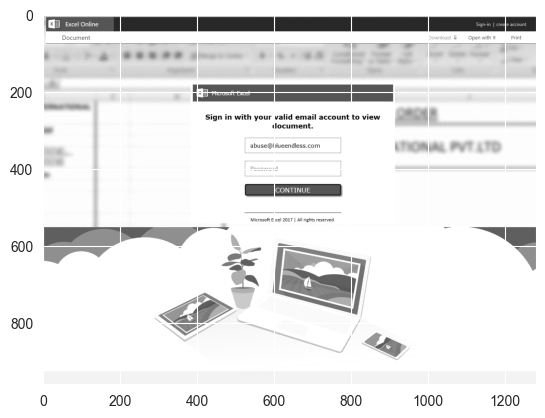

474: 0.7408


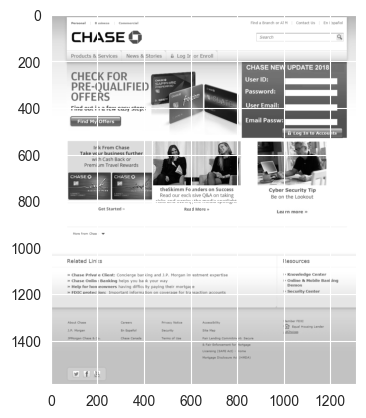

643: 0.7368


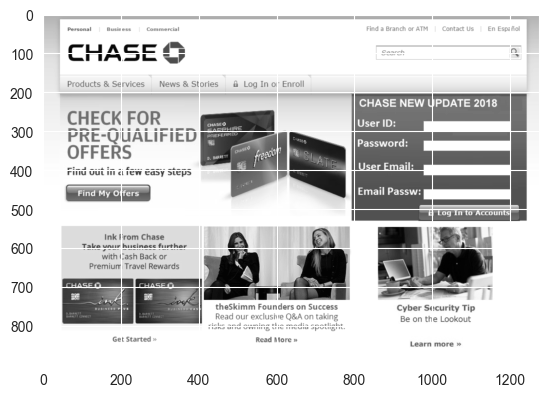

365: 0.7329


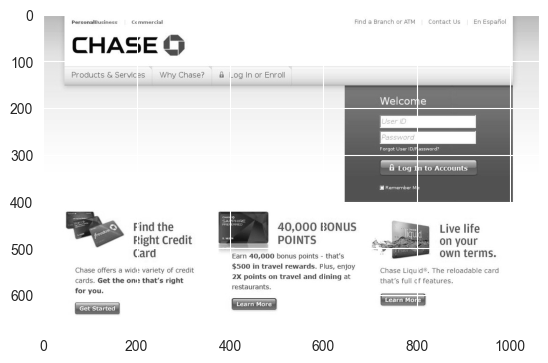

array([647,  10, 474, 643, 365])

In [73]:
search_test(10)

Search image:


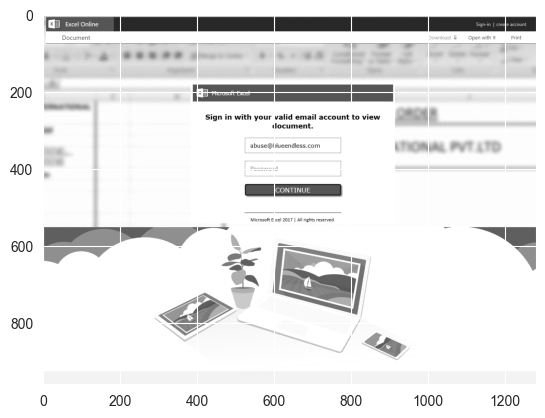

-----------------------------------------------------
647: 1.0


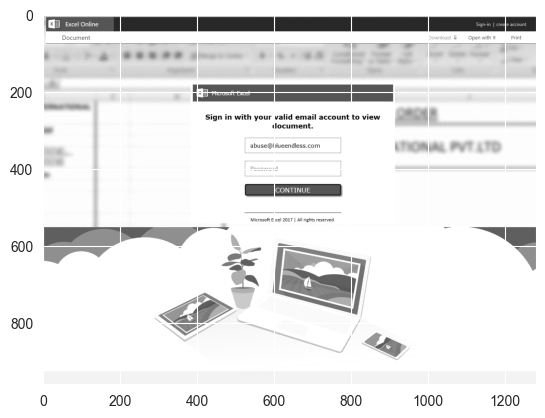

10: 1.0


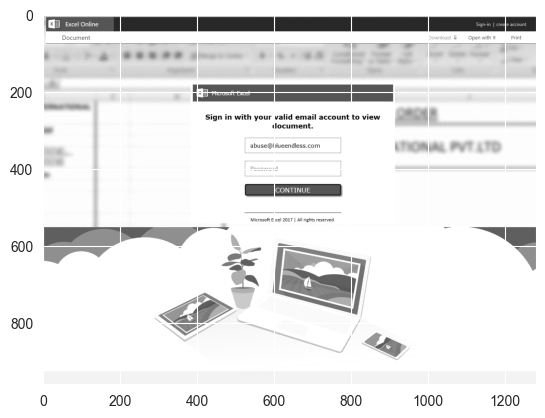

474: 0.7408


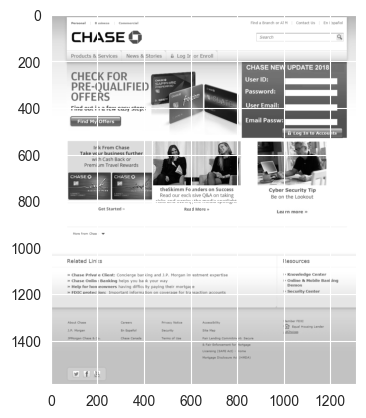

643: 0.7368


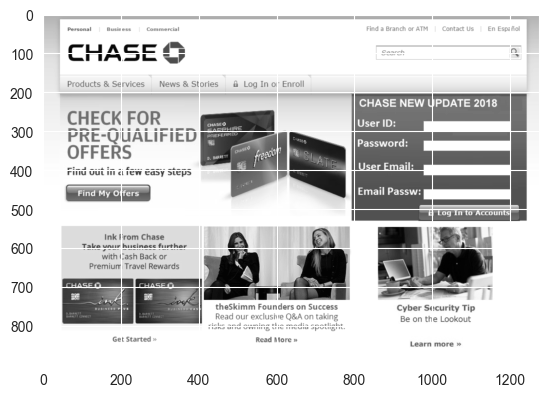

365: 0.7329


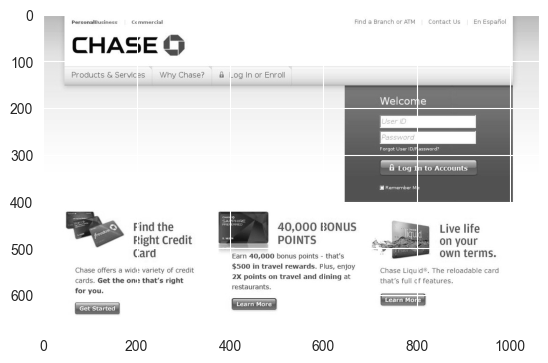

array([647,  10, 474, 643, 365])

In [74]:
search(10)

Search image:


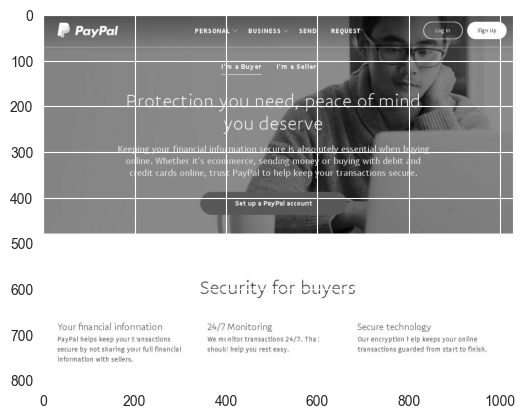

-----------------------------------------------------
515: 0.8652


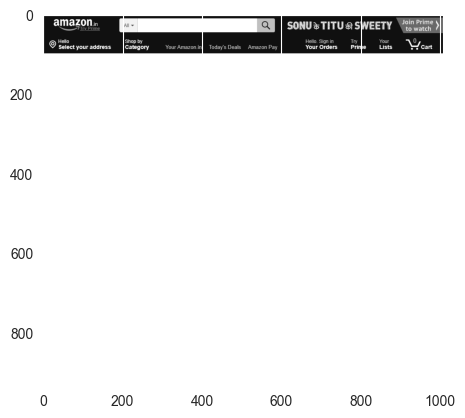

56: 0.8652


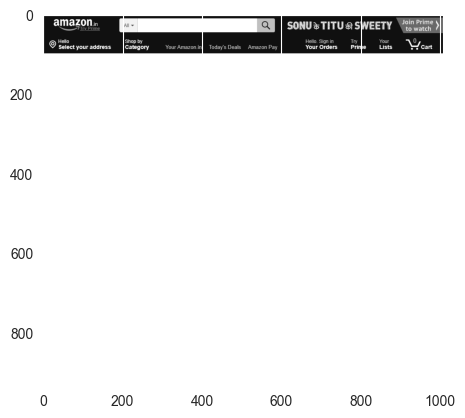

80: 0.8197


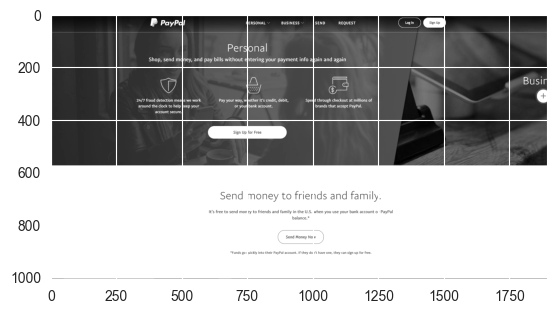

419: 0.8142


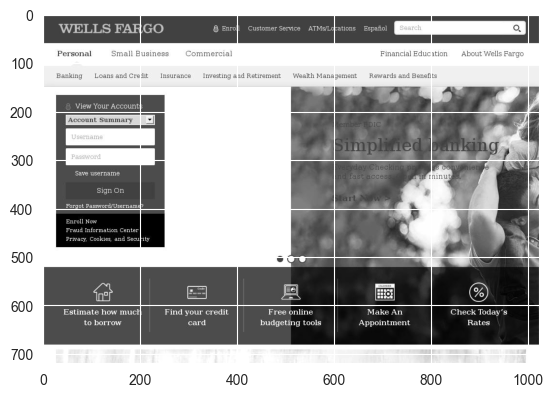

525: 0.8133


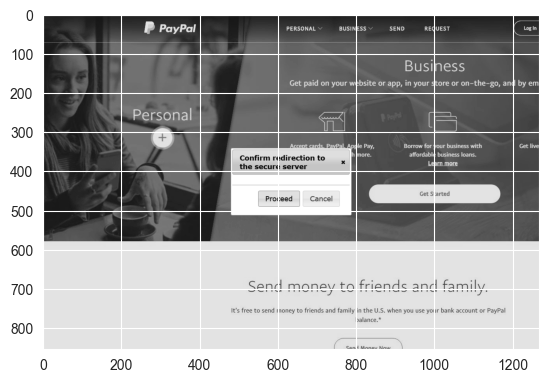

In [63]:
search_test(112)

Search image:


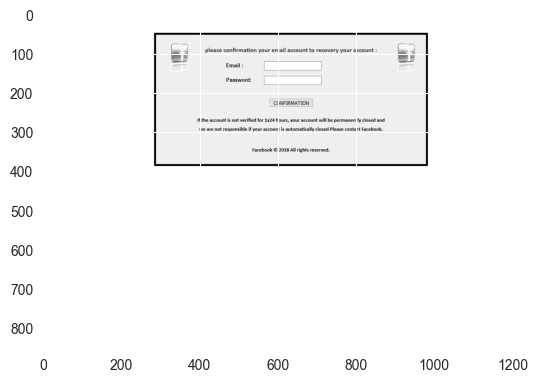

-----------------------------------------------------
10: 1.0


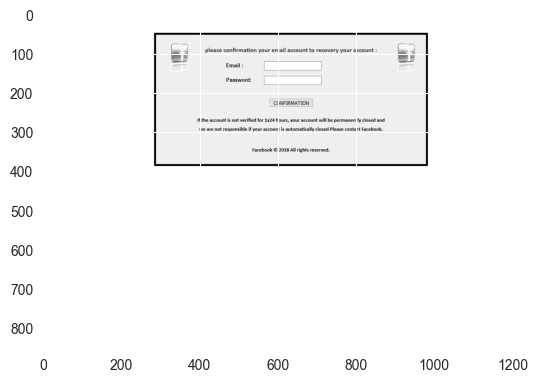

492: 0.7632


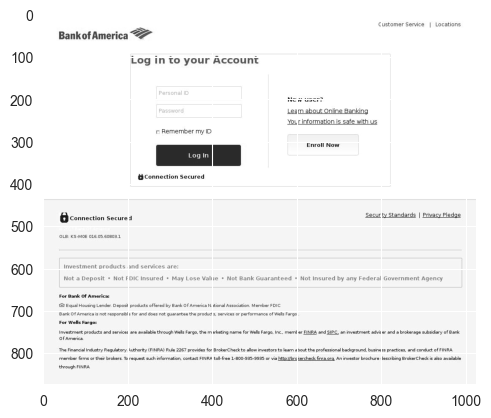

371: 0.7632


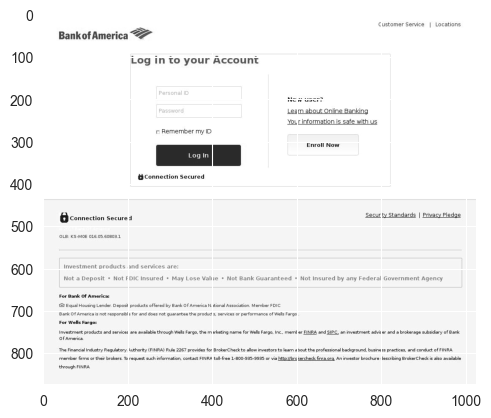

166: 0.7562


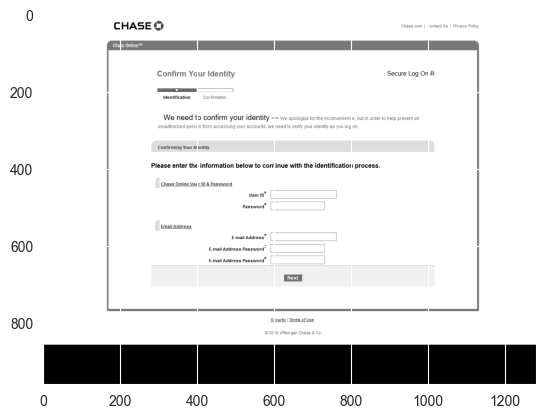

669: 0.7562


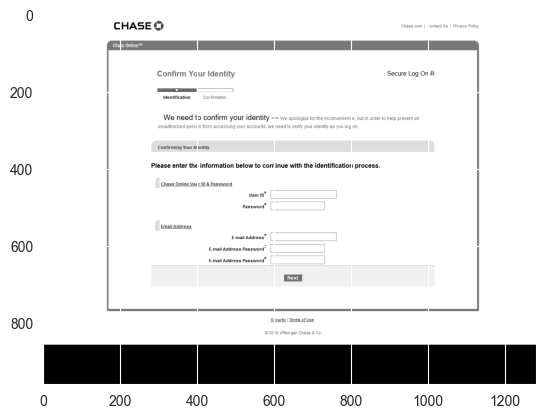

In [39]:
search(10)

Search image:


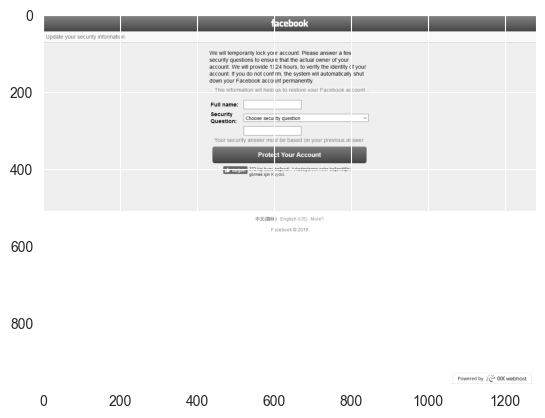

-----------------------------------------------------
710: 1.0


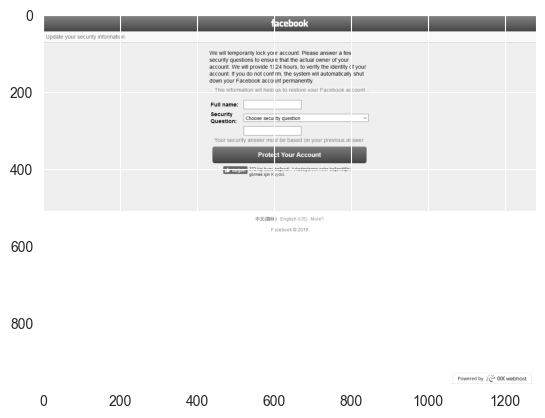

704: 0.8025


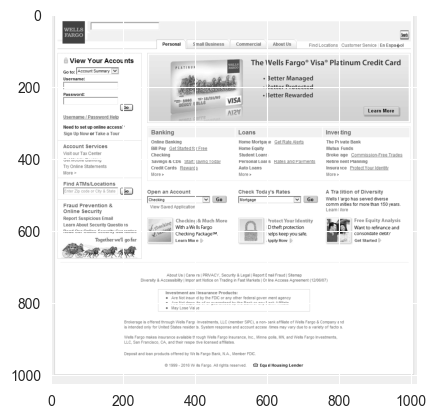

603: 0.7848


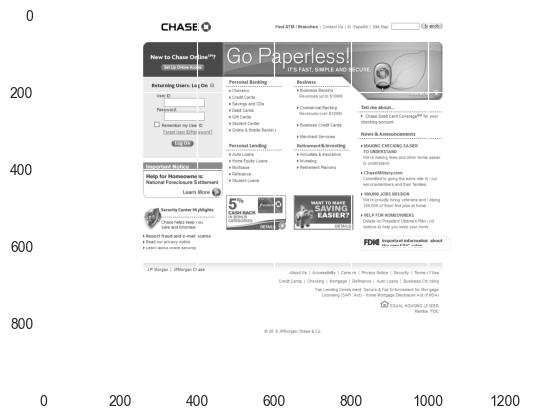

32: 0.7743


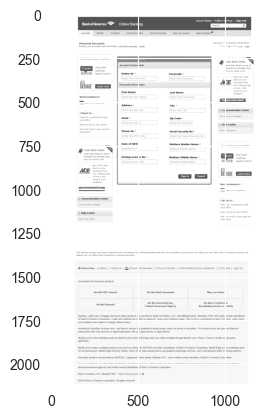

72: 0.7721


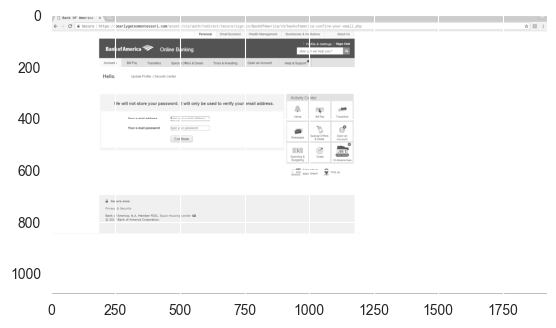

In [40]:
search(710)